In [1]:
import graphviz
import spacy

nlp = spacy.load('en') 

In [2]:
test_sent = nlp("""It is also recognised that the body of the receptacle can be configured to include only one resilient arm that is biased with respect to the wall of the body, thus facilitating the retention of the stylus between the one arm and the wall (and/or other rigid secondary structures of the body).""")

Direction in the graph is set by the parent>child relationship in the dependency parse. Nodes are the word tokens. I need to recursively navigate the dependency tree adding nodes and their relationships.

In [43]:
def build_graph(node):
    """ Print the subtree of a node."""
    # Add node to graph
    node_name = "{0}_{1}_{2}_{3}".format(node.text, node.tag_, node.dep_, node.i)
    dot.node(node_name)
    if node.children: # This will always be true as node.children is a generator
        for child in node.children:
            child_name = build_graph(child)
            dot.edge(node_name, child_name)
    return node_name

In [44]:
dot = graphviz.Digraph(comment='Dependency Tree')

In [45]:
root = list(test_sent.sents)[0].root
build_graph(root)

'recognised_VBN_ROOT_3'

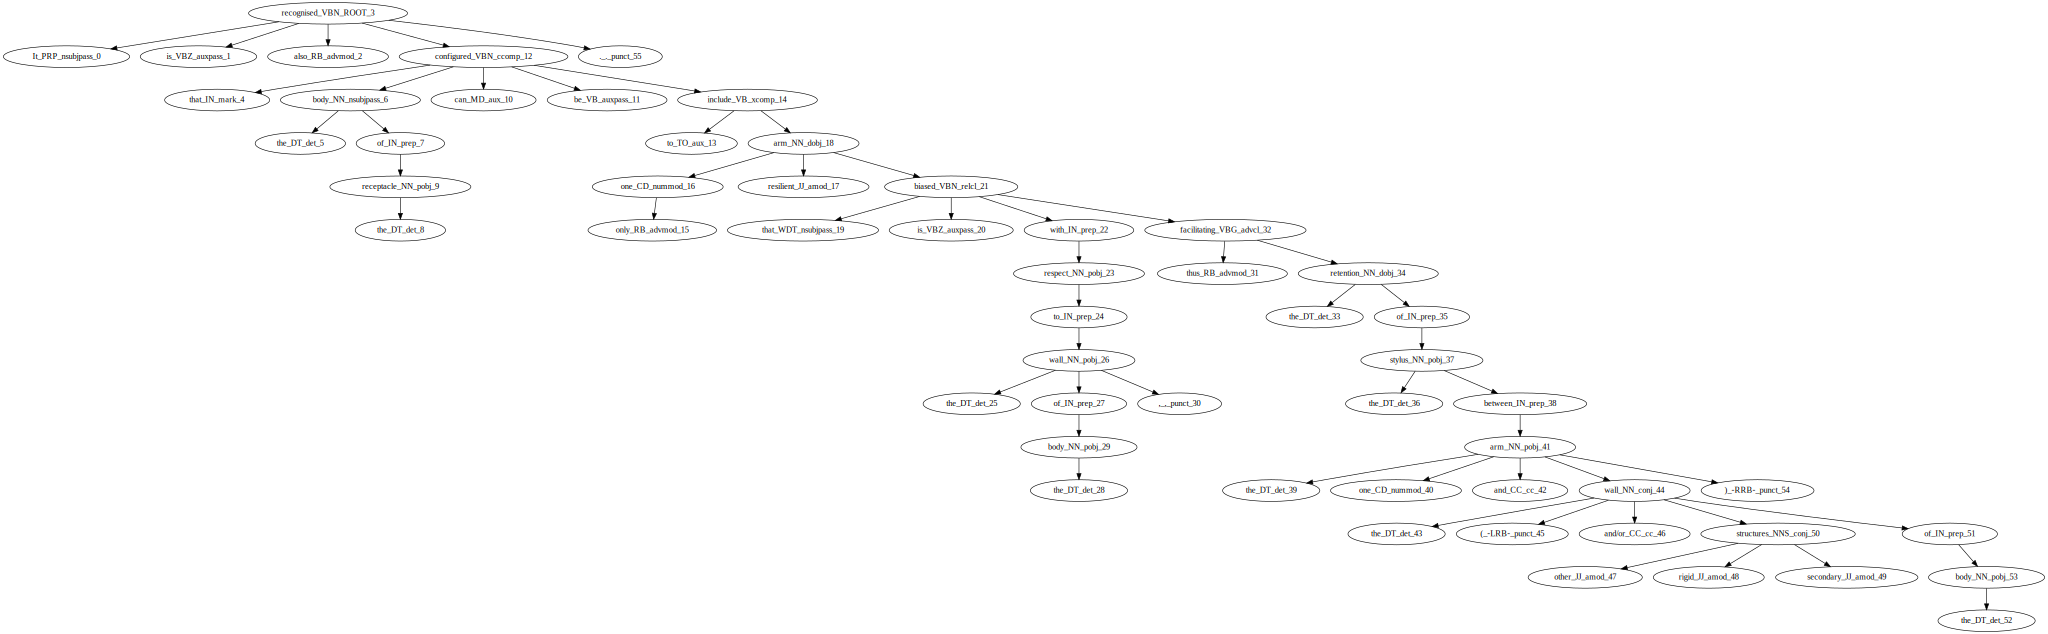

In [46]:
dot

In [47]:
dot.format = 'png'
dot.render()

'Digraph.gv.png'

Cool!

This helps a lot. We need to filter out nodes that have no children. The nodes that have children we can substitute in the graph and then handle the node + children separately.  

So we need to extract the subgraphs. Test is if child has children replace child with placeholder and add child structure to separate list.   

Process by layer at a time. Can we filter by size of subtree (e.g. in terms of number of nodes)? What we really want are the main subtrees not the puny little DET from NOUN subtrees.  

It's to do with numbers of children of subtrees.  

I think the spaCy visualiser groups all subtrees with only one child into a chunk.  


START FROM TERMINAL NODES WITH ONE PARENT - these can be folded up as there is only one pattern CHILD PARENT or PARENT CHILD

In [21]:
print(dot.source)

// Dependency Tree
digraph {
	recognised_VERB_ROOT_3
	It_PRON_nsubjpass_0
	recognised_VERB_ROOT_3 -> It_PRON_nsubjpass_0
	is_VERB_auxpass_1
	recognised_VERB_ROOT_3 -> is_VERB_auxpass_1
	also_ADV_advmod_2
	recognised_VERB_ROOT_3 -> also_ADV_advmod_2
	configured_VERB_ccomp_12
	that_ADP_mark_4
	configured_VERB_ccomp_12 -> that_ADP_mark_4
	body_NOUN_nsubjpass_6
	the_DET_det_5
	body_NOUN_nsubjpass_6 -> the_DET_det_5
	of_ADP_prep_7
	receptacle_NOUN_pobj_9
	the_DET_det_8
	receptacle_NOUN_pobj_9 -> the_DET_det_8
	of_ADP_prep_7 -> receptacle_NOUN_pobj_9
	body_NOUN_nsubjpass_6 -> of_ADP_prep_7
	configured_VERB_ccomp_12 -> body_NOUN_nsubjpass_6
	can_VERB_aux_10
	configured_VERB_ccomp_12 -> can_VERB_aux_10
	be_VERB_auxpass_11
	configured_VERB_ccomp_12 -> be_VERB_auxpass_11
	include_VERB_xcomp_14
	to_PART_aux_13
	include_VERB_xcomp_14 -> to_PART_aux_13
	arm_NOUN_dobj_18
	one_NUM_nummod_16
	only_ADV_advmod_15
	one_NUM_nummod_16 -> only_ADV_advmod_15
	arm_NOUN_dobj_18 -> one_NUM_nummod_16
	resilient_

In [27]:
subtrees = list()
parse_list = list()

def split_sentence(node):
    if node.children:
        layer_below = list()
        for child in node.lefts:
            if list(child.children):
                # Replace with token
                subtrees.append(child)
                layer_below.append(len(subtrees))
                # Split Sentence on token
                split_sentence(child)
            else:
                # Add to list of tokens we can print
                layer_below.append(child)
                
        layer_below.append(node)
        
        for child in node.rights:
            if list(child.children):
                # Replace with token
                subtrees.append(child)
                layer_below.append(len(subtrees))
                # Split Sentence on token
                split_sentence(child)
            else:
                # Add to list of tokens we can print
                layer_below.append(child)
    
    parse_list.append(layer_below)

In [28]:
split_sentence(root)

In [29]:
subtrees

[configured,
 body,
 of,
 receptacle,
 include,
 arm,
 one,
 biased,
 with,
 respect,
 to,
 wall,
 of,
 body,
 facilitating,
 retention,
 of,
 stylus,
 between,
 arm,
 wall,
 structures,
 of,
 body]

In [30]:
parse_list

[[the, receptacle],
 [of, 4],
 [the, body, 3],
 [only, one],
 [the, body],
 [of, 14],
 [the, wall, 13, ,],
 [to, 12],
 [respect, 11],
 [with, 10],
 [other, rigid, secondary, structures],
 [the, body],
 [of, 24],
 [the, wall, (, and/or, 22, 23],
 [the, one, arm, and, 21, )],
 [between, 20],
 [the, stylus, 19],
 [of, 18],
 [the, retention, 17],
 [thus, facilitating, 16],
 [that, is, biased, 9, 15],
 [7, resilient, arm, 8],
 [to, include, 6],
 [that, 2, can, be, configured, 5],
 [It, is, also, recognised, 1, .]]

Now we can add some rules to collapse trees with two or fewer children that are not PUNCT.

So:
* Get list of children not equal to PUNCT.
* If list < 3: do something.

I think we will need to prune the existing structures. We thus need the subtrees to be a dict as we will be modifying the list when merging.

In [34]:
len({"a":1, "b":2})

2

In [39]:
st = {}
st[1] = 2

In [40]:
st

{1: 2}

In [41]:
subtrees = dict()
parse_list = list()

def process_node(node):
    
    if list(node.children):
        # Replace with token
        token = len(subtrees)+1
        subtrees[token] = node
        list_entry = token
        # Split Sentence on token
        split_sentence(node)
    else:
        # Add to list of tokens we can print
        list_entry = node
    return list_entry

def split_sentence(node):
    if node.children:
        layer_below = list()
        for child in node.lefts:
            layer_below.append(process_node(child))
                
        layer_below.append(node)
        
        for child in node.rights:
            layer_below.append(process_node(child))
    
    parse_list.append(layer_below)

In [42]:
subtrees = dict()
parse_list = list()
split_sentence(root)
print(subtrees)
print(list(reversed(parse_list)))

{1: configured, 2: body, 3: of, 4: receptacle, 5: include, 6: arm, 7: one, 8: biased, 9: with, 10: respect, 11: to, 12: wall, 13: of, 14: body, 15: facilitating, 16: retention, 17: of, 18: stylus, 19: between, 20: arm, 21: wall, 22: structures, 23: of, 24: body}
[[It, is, also, recognised, 1, .], [that, 2, can, be, configured, 5], [to, include, 6], [7, resilient, arm, 8], [that, is, biased, 9, 15], [thus, facilitating, 16], [the, retention, 17], [of, 18], [the, stylus, 19], [between, 20], [the, one, arm, and, 21, )], [the, wall, (, and/or, 22, 23], [of, 24], [the, body], [other, rigid, secondary, structures], [with, 10], [respect, 11], [to, 12], [the, wall, 13, ,], [of, 14], [the, body], [only, one], [the, body, 3], [of, 4], [the, receptacle]]


Now to flatten small subtrees we iterate through the subtrees dictionary.

We can group subtrees.

Phrase-based grammars work on a layer by layer basis where a rule in the grammar moves between (i.e. down) layers.  

So what we are looking for are tokens that replace nodes where the tokens of the layer below are constant. For example, if we had the repeated pattern of "ADJ NOUN NOUN" that formed an entry in the subtrees then this would be a categorial label.

I think it may be easier to build a parallel tree where each node is linked to one or more tokens rather than use the tokens as the tree.

We can then map our "graph" object to the graphviz to visualise. There is a ready made class here: https://www.python-course.eu/graphs_python.php

In [124]:
from collections import OrderedDict

class Graph(object):
    """ Based on object here - https://www.python-course.eu/graphs_python.php"""
    
    
    def __init__(self, graph_dict=None):
        """ initializes a graph object 
            If no dictionary or None is given, 
            an empty dictionary will be used
        """
        if graph_dict == None:
            graph_dict = OrderedDict()
        self.__graph_dict = graph_dict
        self.__token_dict = OrderedDict()

    @property
    def nodes(self):
        """ returns the nodes of a graph """
        return list(self.__graph_dict.keys())

    @property
    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()

    def add_node(self, node, tokens=None):
        """ If the node "node" is not in 
            self.__graph_dict, a key "node" with an empty
            list as a value is added to the dictionary. 
            Otherwise nothing has to be done. 
        """
        if node not in self.__graph_dict:
            self.__graph_dict[node] = []
            self.__token_dict[node] = tokens

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list; 
            between two nodes can be multiple edges! 
        """
        (node1, node2) = tuple(edge)
        if node1 in self.__graph_dict:
            self.__graph_dict[node1].append(node2)
        else:
            self.__graph_dict[node1] = [node2]

    def __generate_edges(self):
        """ A static method generating the edges of the 
            graph "graph". Edges are represented as sets 
            with one (a loop back to the node) or two 
            node 
        """
        edges = []
        for node in self.__graph_dict:
            for neighbour in self.__graph_dict[node]:
                if (neighbour, node) not in edges:
                    edges.append((node, neighbour))
        return edges

    def __str__(self):
        res = "nodes: "
        for k in self.__graph_dict:
            res += str(k) + " "
        res += "\nedges: "
        for edge in self.__generate_edges():
            res += str(edge) + " "
        return res
    
    def merge_nodes(self, nodes):
        """Merge two nodes"""
        pass
    
    def remove_node(self, node):
        pass
    
    def remove_edge(self, edge):
        pass
    
    def get_graphviz(self):
        """ Visualise via Graphviz."""
        gv = graphviz.Digraph()
        for node in self.nodes:
            gv.node(node)
        for node1, node2 in self.edges:
            gv.edge(node1, node2)
        return gv
    
    def build_graph(self, token):
        """ Print a graph ."""
        # Add node to graph
        node_name = "{0}_{1}_{2}_{3}".format(token.text, token.tag_, token.dep_, token.i)
        self.add_node(node_name, token)
        for child in token.children:
            child_name = self.build_graph(child)
            self.add_edge((node_name, child_name))
        return node_name
        

In [125]:
g = Graph()
g.add_node("A")
g.add_node("B")
g.add_edge("BA")
print(g)

nodes: A B 
edges: ('B', 'A') 


Graph is not directed! Need to modify the edge implementation. DONE - it was the "set" that was reversing the order.

In [126]:
g_r = Graph()
g_r.build_graph(root)

'recognised_VBN_ROOT_3'

In [121]:
g_r._Graph__graph_dict

OrderedDict([('recognised_VBN_ROOT_3',
              ['It_PRP_nsubjpass_0',
               'is_VBZ_auxpass_1',
               'also_RB_advmod_2',
               'configured_VBN_ccomp_12',
               '._._punct_55']),
             ('It_PRP_nsubjpass_0', []),
             ('is_VBZ_auxpass_1', []),
             ('also_RB_advmod_2', []),
             ('configured_VBN_ccomp_12',
              ['that_IN_mark_4',
               'body_NN_nsubjpass_6',
               'can_MD_aux_10',
               'be_VB_auxpass_11',
               'include_VB_xcomp_14']),
             ('that_IN_mark_4', []),
             ('body_NN_nsubjpass_6', []),
             ('the_DT_det_5', ['body_NN_nsubjpass_6']),
             ('of_IN_prep_7', ['body_NN_nsubjpass_6']),
             ('receptacle_NN_pobj_9', ['of_IN_prep_7']),
             ('the_DT_det_8', ['receptacle_NN_pobj_9']),
             ('can_MD_aux_10', []),
             ('be_VB_auxpass_11', []),
             ('include_VB_xcomp_14', ['to_TO_aux_13', 'arm_NN

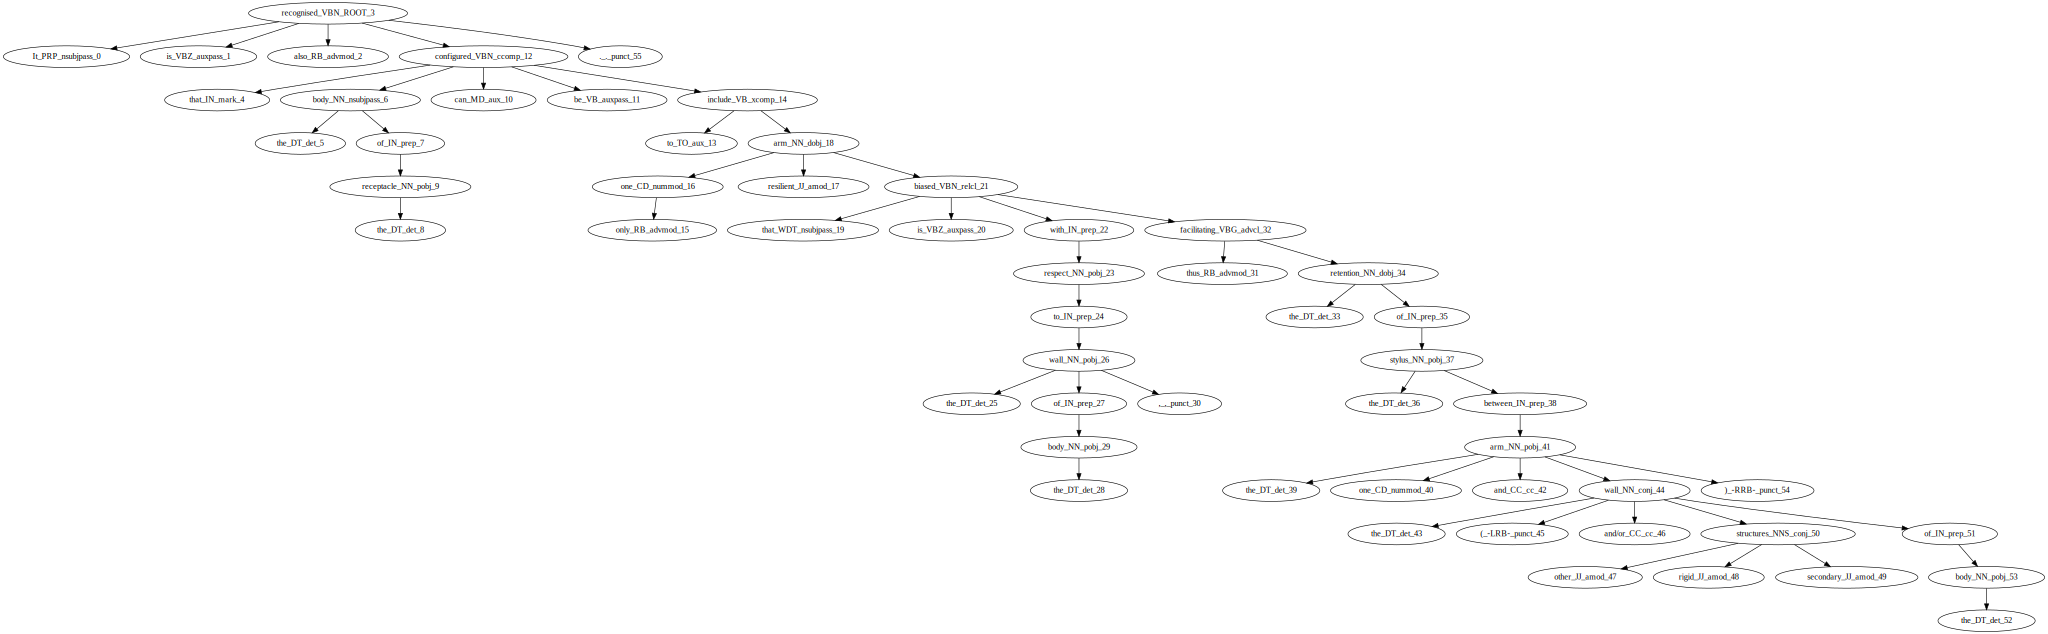

In [128]:
gv = g_r.get_graphviz()
gv

Issue is that the order you add the nodes is important for graphviz - the list of nodes is returned in a different order? No some of these arrows are the wrong way.

In [69]:
g.edges()

[{'receptacle_NN_pobj_9', 'the_DT_det_8'},
 {'arm_NN_dobj_18', 'resilient_JJ_amod_17'},
 {'biased_VBN_relcl_21', 'that_WDT_nsubjpass_19'},
 {',_,_punct_30', 'wall_NN_pobj_26'},
 {'configured_VBN_ccomp_12', 'that_IN_mark_4'},
 {'body_NN_nsubjpass_6', 'configured_VBN_ccomp_12'},
 {'can_MD_aux_10', 'configured_VBN_ccomp_12'},
 {'be_VB_auxpass_11', 'configured_VBN_ccomp_12'},
 {'configured_VBN_ccomp_12', 'include_VB_xcomp_14'},
 {'respect_NN_pobj_23', 'to_IN_prep_24'},
 {'respect_NN_pobj_23', 'with_IN_prep_22'},
 {'secondary_JJ_amod_49', 'structures_NNS_conj_50'},
 {'body_NN_nsubjpass_6', 'of_IN_prep_7'},
 {'biased_VBN_relcl_21', 'is_VBZ_auxpass_20'},
 {'body_NN_pobj_29', 'of_IN_prep_27'},
 {'of_IN_prep_27', 'wall_NN_pobj_26'},
 {'body_NN_nsubjpass_6', 'the_DT_det_5'},
 {'body_NN_pobj_29', 'the_DT_det_28'},
 {'arm_NN_pobj_41', 'the_DT_det_39'},
 {'It_PRP_nsubjpass_0', 'recognised_VBN_ROOT_3'},
 {'is_VBZ_auxpass_1', 'recognised_VBN_ROOT_3'},
 {'also_RB_advmod_2', 'recognised_VBN_ROOT_3'},
 

In [123]:
edge = set(("parent", "child"))
print(edge)

{'child', 'parent'}


In [70]:
        (node1, node2) = tuple(edge)
        if node1 in self.__graph_dict:
            self.__graph_dict[node1].append(node2)
        else:
            self.__graph_dict[node1] = [node2]

// Dependency Tree
digraph {
	recognised_VBN_ROOT_3
	It_PRP_nsubjpass_0
	recognised_VBN_ROOT_3 -> It_PRP_nsubjpass_0
	is_VBZ_auxpass_1
	recognised_VBN_ROOT_3 -> is_VBZ_auxpass_1
	also_RB_advmod_2
	recognised_VBN_ROOT_3 -> also_RB_advmod_2
	configured_VBN_ccomp_12
	that_IN_mark_4
	configured_VBN_ccomp_12 -> that_IN_mark_4
	body_NN_nsubjpass_6
	the_DT_det_5
	body_NN_nsubjpass_6 -> the_DT_det_5
	of_IN_prep_7
	receptacle_NN_pobj_9
	the_DT_det_8
	receptacle_NN_pobj_9 -> the_DT_det_8
	of_IN_prep_7 -> receptacle_NN_pobj_9
	body_NN_nsubjpass_6 -> of_IN_prep_7
	configured_VBN_ccomp_12 -> body_NN_nsubjpass_6
	can_MD_aux_10
	configured_VBN_ccomp_12 -> can_MD_aux_10
	be_VB_auxpass_11
	configured_VBN_ccomp_12 -> be_VB_auxpass_11
	include_VB_xcomp_14
	to_TO_aux_13
	include_VB_xcomp_14 -> to_TO_aux_13
	arm_NN_dobj_18
	one_CD_nummod_16
	only_RB_advmod_15
	one_CD_nummod_16 -> only_RB_advmod_15
	arm_NN_dobj_18 -> one_CD_nummod_16
	resilient_JJ_amod_17
	arm_NN_dobj_18 -> resilient_JJ_amod_17
	biased_VBN_